how to define a session?

- end of session determined by period of inactivity?
- start of session is determined by and action type
- how to make this work with a loading funnel?


In [1]:
import pandas as pd, psycopg2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def query_database(connection, sql, *args, **kwargs):
    if connection.get_transaction_status() == 3:
        connection.reset()
    with connection.cursor() as cursor:
        cursor.execute(sql, *args, **kwargs)
        rows = cursor.fetchall()
        columns = [d[0] for d in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [3]:
connection = psycopg2.connect('postgres://fga@localhost/fga')

In [25]:
sql = '''
with events_ as (
    select
        "createdAt"::timestamp as ts,
        "currentUser" as user_id,
        "userDevice" as device_id
        
    from events

), ordered_events as (
    select
        ts,
        device_id,
        row_number() over (partition by device_id order by ts)
        
    from events_
    
), previous_events as (
    select
        c.device_id,
        c.ts,
        p.ts as previous_ts,
        c.ts - p.ts as delta_previous,
        n.ts - c.ts as delta_next
        
    from ordered_events c
        left join ordered_events p on c.device_id = p.device_id
            and c.row_number = p.row_number + 1
        left join ordered_events n on c.device_id = n.device_id
            and c.row_number = n.row_number - 1
        
), sessionised_events as (
    select
        device_id,
        ts,
        case
            when delta_previous >= interval '20 minutes' or delta_previous is null then true
            else false
        end as is_session_start,
        case
            when delta_next > interval '20 minutes' or delta_next is null then true
            else false
        end as is_session_end
        
    from previous_events

), session_transitions as (
    select
        device_id,
        ts,
        is_session_start,
        is_session_end,
        row_number() over (partition by device_id order by ts)
        
    from sessionised_events
    
    where is_session_start = true
        or is_session_end = true

), sessions_ as (
    select
        l.device_id,
        l.ts as session_start,
        r.ts as session_end
        
    from session_transitions l 
        join session_transitions r on l.device_id = r.device_id
            and l.row_number = r.row_number - 1
            
    where l.is_session_start = true
        and r.is_session_end = true
        
), sessions

select * from sessions

'''

df = query_database(connection, sql)
df.head()

,device_id,session_start,session_end,session_id
0,00000000-0000-0000-0000-000000000000,2019-10-14 12:15:55.652458,2019-10-14 12:39:35.049801,1
1,00000000-0000-0000-0000-000000000000,2019-10-14 13:33:59.002657,2019-10-14 13:59:45.760648,2
2,00000000-0000-0000-0000-000000000000,2019-10-14 14:41:48.350425,2019-10-14 15:13:42.704183,3
3,00000000-0000-0000-0000-000000000000,2019-10-14 16:59:17.703267,2019-10-14 17:25:48.727183,4
4,00000000-0000-0000-0000-000000000000,2019-10-14 17:47:35.311865,2019-10-14 18:34:43.481977,5


In [30]:
import sqlalchemy

In [32]:
engine = sqlalchemy.create_engine('postgres://fga@localhost/fga')

In [34]:
df.to_sql('sessions', engine)

In [53]:
sql = '''
with devices_ as (
    select
        "Id" as device_id,
        "DeviceOS" as client
        
    from devices
    
), sessions_ as (
    select
        device_id,
        client,
        session_start,
        session_end,
        session_id,
        session_end - session_start as session_length
        
    from sessions join devices_ using (device_id)
        
), results_mean as (
    select
        session_start::date as date,
        client,
        avg(session_length) as mean_session_length
        
    from sessions_
    
    group by 1, 2
    
    order by 1, 2
    
), results_median as (
    select 
        session_start::date as date,
        client,
        percentile_disc(0.5) within group (order by session_length) as median_session_length
    
    from sessions_
    
    group by 1, 2
    
    order by 1, 2
    
), results as (
    select * from results_mean join results_median using (date, client)
)

select * from results

'''

df = query_database(connection, sql)
df.head()

,date,client,mean_session_length,median_session_length
0,2019-10-14,Android,00:03:34.646247,00:01:43.844370
1,2019-10-14,iOS,00:03:01.483257,00:01:20.531682
2,2019-10-15,Android,00:03:21.936692,00:01:15.906727
3,2019-10-15,iOS,00:02:54.890108,00:01:00.297224
4,2019-10-16,Android,00:03:30.650516,00:01:15.016079


In [65]:
df['mean_session_length'] = df['mean_session_length'].dt.seconds / 60
df['median_session_length'] = df['median_session_length'].dt.seconds / 60

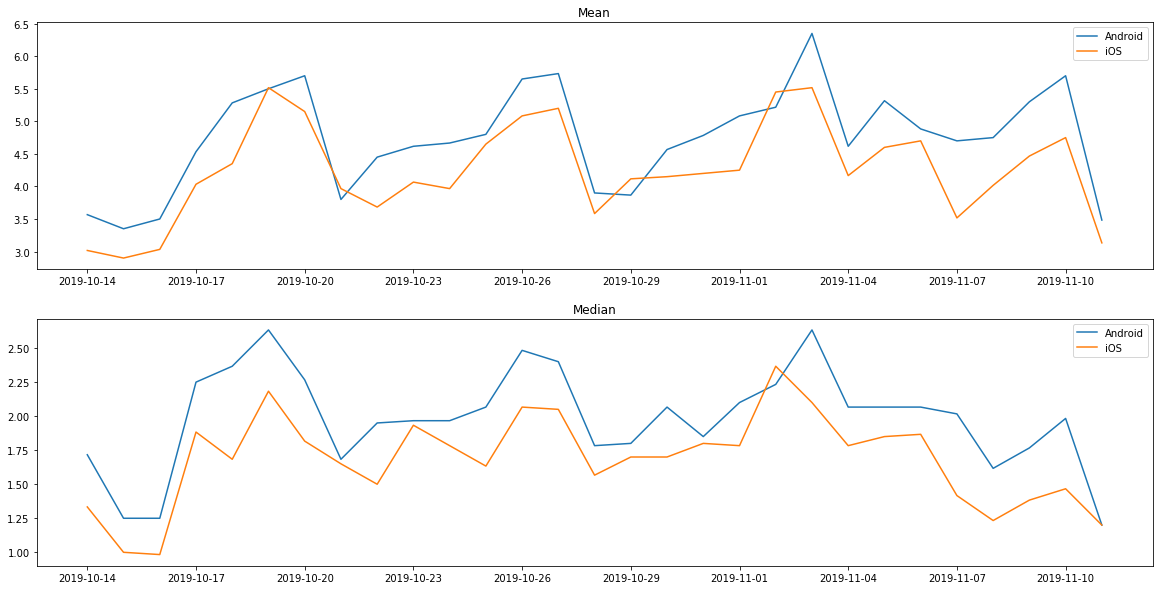

In [66]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
for i, variable in enumerate(['mean', 'median']):
    ax = axes[i]
    for client, df_ in df.groupby('client'):
        ax.plot(df_['date'], df_[f'{variable}_session_length'], label=client)
    ax.legend()
    ax.set_title(variable.title())